## Libraries Needed

In [ ]:
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0  # notice the precise version
import torch
from torchvision import transforms, datasets
from torch.utils import data
from d2l import torch as d2l
import numpy as np
import matplotlib.pyplot as plt
d2l.use_svg_display()
%matplotlib inline
import os
import random
import shutil
import torch.nn as nn
import torch.optim as optim
from torchvision import models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.9 MB/s eta 0:00:00


In [ ]:
d2l.try_gpu()

device(type='cuda', index=0)

In [ ]:
# Chunk to mount the google drive into the colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DEEP LEARING PROJECT: Age Prediction

## Authors: Simone Dal Ben, Paolo Mantovani

In this project, our objective is to develop image classification models for the "Age Prediction" dataset, which can be accessed via the following link: [Age Prediction](https://www.kaggle.com/datasets/mariafrenti/age-prediction). The primary goal is to predict the age of an individual, specifically within the age range of 20 to 50, based on provided portrait photographs.

The dataset has been pre-divided into training and testing sets. Notably, it is organized into 31 distinct classes, each representing a unique age between 20 and 50. For computational reasons, we decided to reduce the class dimensions by selecting 300 images per class from the training set and 100 images per class from the test set. Consequently, the final training set comprises 9300 images, while the test set consists of 3100 images.

Furthermore, the images in the dataset are standardized to a resolution of 128x128 pixels and exhibit color variations, with occasional instances of black and white images.

In [ ]:
%cd /content/drive/MyDrive/deep_learning_project

/content/drive/.shortcut-targets-by-id/1AvqssdmaGfEg2xRgzRXoQRBkh9gRNxPr/deep_learning_project


This is what we have in our "deep_learning_project" folder on Google Drive.

In [ ]:
%ls -al

Here we can see what's inside the 'train' folder.

In [ ]:
%ls -al 20-50/train

total 124
drwx------ 2 root root 4096 Dec  5 11:02 20/
drwx------ 2 root root 4096 Dec  5 11:02 21/
drwx------ 2 root root 4096 Dec  5 11:02 22/
drwx------ 2 root root 4096 Dec  5 11:02 23/
drwx------ 2 root root 4096 Dec  5 11:03 24/
drwx------ 2 root root 4096 Dec  5 11:03 25/
drwx------ 2 root root 4096 Dec  5 11:03 26/
drwx------ 2 root root 4096 Dec  5 11:03 27/
drwx------ 2 root root 4096 Dec  5 11:03 28/
drwx------ 2 root root 4096 Dec  5 11:03 29/
drwx------ 2 root root 4096 Dec  5 11:03 30/
drwx------ 2 root root 4096 Dec  5 11:04 31/
drwx------ 2 root root 4096 Dec  5 11:04 32/
drwx------ 2 root root 4096 Dec  5 11:04 33/
drwx------ 2 root root 4096 Dec  5 11:04 34/
drwx------ 2 root root 4096 Dec  5 11:04 35/
drwx------ 2 root root 4096 Dec  5 11:04 36/
drwx------ 2 root root 4096 Dec  5 11:04 37/
drwx------ 2 root root 4096 Dec  5 11:05 38/
drwx------ 2 root root 4096 Dec  5 11:05 39/
drwx------ 2 root root 4096 Dec  5 11:05 40/
drwx------ 2 root root 4096 Dec  5 11:05 41/


## Image Dataset preparation

In this section we prepared the data for the analysis.

First of all we took 300 images for each class in the train set folder and 100 in the test set.

In [ ]:
# Main folder for the train set containing our classes
main_folder = '/content/drive/MyDrive/deep_learning_project/20-50/train'

# Function to limit the number of images for every class to the value 'max_images'
def limit_images_in_folder(folder_path, max_images):
    images = os.listdir(folder_path)
    if len(images) > max_images:
        images_to_remove = len(images) - max_images
        images_to_remove = random.sample(images, images_to_remove)
        for image in images_to_remove:
            image_path = os.path.join(folder_path, image)
            os.remove(image_path)

for subdir in os.listdir(main_folder):
    subdir_path = os.path.join(main_folder, subdir)

    # taking max_images = 300
    limit_images_in_folder(subdir_path, 300)


In [ ]:
main_folder = '/content/drive/MyDrive/deep_learning_project/20-50/test'

def limit_images_in_folder(folder_path, max_images):
    images = os.listdir(folder_path)
    if len(images) > max_images:
        images_to_remove = len(images) - max_images
        images_to_remove = random.sample(images, images_to_remove)
        for image in images_to_remove:
            image_path = os.path.join(folder_path, image)
            os.remove(image_path)

for subdir in os.listdir(main_folder):
    subdir_path = os.path.join(main_folder, subdir)

    limit_images_in_folder(subdir_path, 100)

In [ ]:
%cd /content/drive/MyDrive/deep_learning_project/20-50

/content/drive/.shortcut-targets-by-id/1AvqssdmaGfEg2xRgzRXoQRBkh9gRNxPr/deep_learning_project/20-50


In the following code we performed a trasformation to our images such that the different models can take them as input.
We used mean and standard deviation of our image dataset that we have calculated in the colab notebook named 'mean_and_std'.
We used also different transformations:

- transforms.Resize((128,128)): to resize our images to a square of 128x128 pixels. Even if our images were supposed to be of that size we used this function to ensure that every image would be of this size.
- transforms.RandomHorizontalFlip(): to flip randomly the image horizontally with a certain probability (default probability: p=0.5)
- transform.ToTensor(): converts the image to a PyTorch tensor.
- transform.Normalize(mean=torch.Tensor(mean), std=torch.Tensor(std)): Normalizes the image tensor by subtracting the mean and dividing by the standard deviation. This transformation helps in keeping the values within a certain range and makes the model training more stable.

In [ ]:
mean = [0.4515, 0.3795, 0.3387]
std = [0.2492, 0.2254, 0.2167]

# Transformation for train set
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean = torch.Tensor(mean), std = torch.Tensor(std))
])

# Transformation for test set
test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean = torch.Tensor(mean), std = torch.Tensor(std))
])

train_dataset_path = './train'
test_dataset_path = './test'

# Create ImageFolders object using the transformations defined for the training set and test set.
train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=test_transform)

# Create DataLoaders for the training dataset and the test dataset.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# first batches:
for batch in train_loader:
    images, ages = batch
    print("Images shape:", images.shape)
    print("Ages:", ages)
    break

for batch in test_loader:
    images, ages = batch
    print("Images shape:", images.shape)
    print("Ages:", ages)
    break


Images shape: torch.Size([64, 3, 128, 128])
Ages: tensor([15, 22, 14, 12, 30, 30, 16, 26, 19,  2, 13,  7, 29, 21,  2, 19, 28, 19,
        29,  4, 15,  4, 19, 17, 10,  8, 30, 21, 10, 23, 18, 17, 22, 23,  7,  8,
         4, 27, 13, 15, 15, 26, 17, 18, 26,  0,  2, 29, 22, 26,  9, 15, 23, 15,
        29, 18,  3, 23, 16, 24,  0,  2, 12, 26])
Images shape: torch.Size([64, 3, 128, 128])
Ages: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


This code generates a visualization of transformed images from the dataset.

In [ ]:
import torchvision
def show_transformed_images(dataset):
  loader = torch.utils.data.DataLoader(dataset, batch_size = 6, shuffle = True)
  batch = next(iter(loader))
  images, labels = batch

  grid = torchvision.utils.make_grid(images, nrow = 3)
  plt.figure(figsize = (11,11))
  plt.imshow(np.transpose(grid, (1,2,0)))
  print('labels: ', labels)

Here we can see 6 images of our dataset taken randomly from the train set to see the transformations we made in the previous chunks.

labels:  tensor([24, 30,  3, 19,  1,  1])


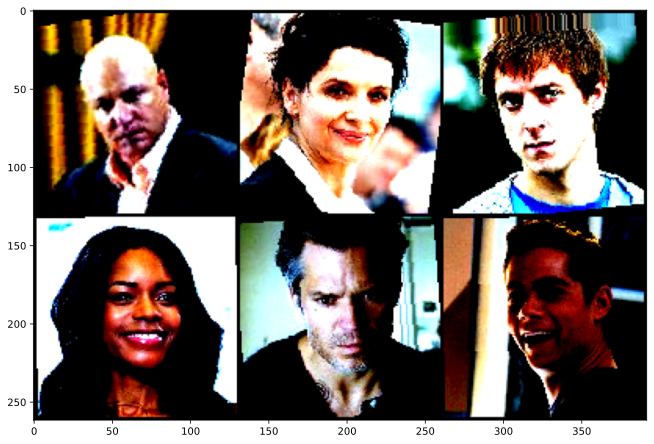

In [ ]:
show_transformed_images(train_dataset)

Here we can see 6 images of our dataset taken randomly from the test set to see the transformations we made in the previous chunks.

labels:  tensor([16,  7,  4, 15,  0, 10])


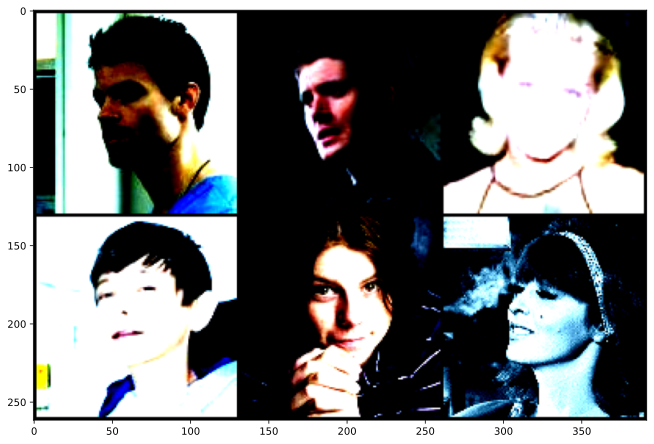

In [ ]:
show_transformed_images(test_dataset)

In these chunks below we can see the dimentions of our dataset

In [ ]:
data_train_iter = iter(train_loader)
X, y = next(data_train_iter)

print("Shape of X (input batch):", X.shape)
print("Shape of y (target labels):", y.shape)
print("Class labels in the minibatch:", y)
print("Is X[0] a PyTorch tensor?", torch.is_tensor(X[0]))

Shape of X (input batch): torch.Size([64, 3, 128, 128])
Shape of y (target labels): torch.Size([64])
Class labels in the minibatch: tensor([13, 29, 17,  8, 13,  8, 28, 29, 21,  5, 15,  8, 18,  6,  5, 23, 28, 16,
        16, 24, 26,  5, 17,  9, 27, 12,  9, 14, 16,  9, 18, 28, 18, 28, 17,  4,
         7, 17, 25,  9,  9, 15,  7,  9,  6,  9,  0,  7, 26,  5,  8, 21, 24, 13,
         4, 19, 19, 11, 30,  4,  4, 27, 25, 15])
Is X[0] a PyTorch tensor? True


In [ ]:
data_test_iter = iter(test_loader)
X, y = next(data_test_iter)

In [ ]:
print("Training and test sample size:", (len(train_dataset), len(test_dataset)))
print("Type and length of the first item:", (type(train_dataset[0]), len(test_dataset[0])))

Training and test sample size: (9300, 3100)
Type and length of the first item: (<class 'tuple'>, 2)


# Models

We performed two different models starting from the AlexNet structure. AlexNet is a convolutional neural network (CNN) architecture that gained significant attention and marked a breakthrough in image classification tasks. It was designed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, and won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. We decided to modify its structure to adapt it for our regression purpose.

Before implementing our networks we have to initialize our weights for our two models. After several trials we decided to use xavier uniform for the weights in the convolutional part because the results are more consistent.

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

## First model

The first model has the following structure:

- 6 convolutional layers
- Different Activation and Pooling Layers: ReLU activation function is applied after each convolutional layer, Batch normalization is applied after each convolutional layer and Max pooling which is applied after some of the convolutional layers.
- 6 fully connected layers.
- Dropout layers that are applied after some of the convolutional and fully connected layers with a dropout probability of 0.25 or 0.5.
- Adaptive average pooling is applied before flattening, reducing the spatial dimensions to (3, 3).
- The final output is a single value (regression output) obtained after passing through the last fully connected layer with a sigmoid activation function.


Epoch 1/20 - Loss: 289.57557636417755
Epoch 2/20 - Loss: 288.93558753026673
Epoch 3/20 - Loss: 288.5499090952416
Epoch 4/20 - Loss: 288.2396084511117
Epoch 5/20 - Loss: 287.82108986214416
Epoch 6/20 - Loss: 287.553996255953
Epoch 7/20 - Loss: 287.207933713312
Epoch 8/20 - Loss: 286.46255691737343
Epoch 9/20 - Loss: 286.1715312591971
Epoch 10/20 - Loss: 286.0116227032387
Epoch 11/20 - Loss: 285.19442278718293
Epoch 12/20 - Loss: 285.10859826492936
Epoch 13/20 - Loss: 284.48410285009095
Epoch 14/20 - Loss: 284.7901208955948
Epoch 15/20 - Loss: 283.876654219954
Epoch 16/20 - Loss: 283.788872705747
Epoch 17/20 - Loss: 283.72730976261505
Epoch 18/20 - Loss: 283.25847186780953
Epoch 19/20 - Loss: 282.9224774086312
Epoch 20/20 - Loss: 281.8723516594874


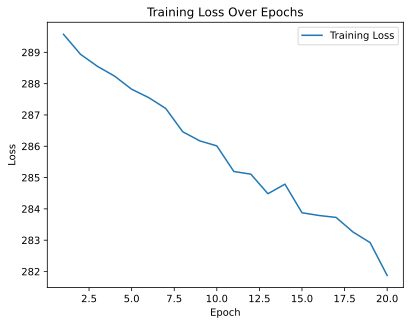

CustomRegression(
  (conv1): Conv2d(3, 32, kernel_size=(8, 8), stride=(2, 2), padding=(4, 4))
  (relu1): ReLU(inplace=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU(inplace=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU(inplace=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (dropout3): Dropout2d(p=0.25, 

In [ ]:
from torch.nn import init
class CustomRegression(nn.Module):
    def __init__(self):
        super(CustomRegression, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=8, stride=2, padding=4)
        self.relu1 = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(p=0.25)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.bn2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout2 = nn.Dropout2d(p=0.25)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=2, padding=2)
        self.relu3 = nn.ReLU(inplace=True)
        self.bn3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout3 = nn.Dropout2d(p=0.25)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=2)
        self.relu4 = nn.ReLU(inplace=True)
        self.bn4 = nn.BatchNorm2d(256)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.dropout4 = nn.Dropout2d(p=0.25)

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=2)
        self.relu5 = nn.ReLU(inplace=True)
        self.bn5 = nn.BatchNorm2d(512)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=2)
        self.relu6 = nn.ReLU(inplace=True)
        self.bn6 = nn.BatchNorm2d(1024)
        self.avgpool6 = nn.AdaptiveAvgPool2d((3,3))

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(9216, 4000)
        self.relu_fc1 = nn.ReLU(inplace=True)
        self.dropout_fc1 = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(4000, 1024)
        self.relu_fc2 = nn.ReLU(inplace=True)
        self.dropout_fc2 = nn.Dropout(p=0.5)

        self.fc3 = nn.Linear(1024, 512)
        self.relu_fc3 = nn.ReLU(inplace=True)
        self.dropout_fc3 = nn.Dropout(p=0.5)

        self.fc4 = nn.Linear(512, 256)
        self.relu_fc4 = nn.ReLU(inplace=True)
        self.dropout_fc4 = nn.Dropout(p=0.5)

        self.fc5 = nn.Linear(256, 64)
        self.relu_fc5 = nn.Sigmoid()
        self.dropout_fc5 = nn.Dropout(p=0.5)

        self.fc6 = nn.Linear(64, 1)
        self.sigm = nn.Sigmoid()  # Output layer for regression

    def forward(self, x):
        out1 = self.conv1(x)
        out1 = self.bn1(out1)
        out1 = self.relu1(out1)
        out1 = self.maxpool1(out1)
        out1 = self.dropout1(out1)

        out2 = self.conv2(out1)
        out2 = self.bn2(out2)
        out2 = self.relu2(out2)
        out2 = self.maxpool2(out2)
        out2 = self.dropout2(out2)

        out3 = self.conv3(out2)
        out3 = self.bn3(out3)
        out3 = self.relu3(out3)
        out3 = self.maxpool3(out3)
        out3 = self.dropout3(out3)

        out4 = self.conv4(out3)
        out4 = self.bn4(out4)
        out4 = self.relu4(out4)
        out4 = self.maxpool4(out4)
        out4 = self.dropout4(out4)

        out5 = self.conv5(out4)
        out5 = self.bn5(out5)
        out5 = self.relu5(out5)
        out5 = self.maxpool5(out5)

        out6 = self.conv6(out5)
        out6 = self.bn6(out6)
        out6 = self.relu6(out6)
        out6 = self.avgpool6(out6)

        out6 = self.flatten(out6)

        out7 = self.fc1(out6)
        out7 = self.relu_fc1(out7)
        out7 = self.dropout_fc1(out7)

        out8 = self.fc2(out7)
        out8 = self.relu_fc2(out8)
        out8 = self.dropout_fc2(out8)

        out9 = self.fc3(out8)
        out9 = self.relu_fc3(out9)
        out9 = self.dropout_fc3(out9)

        out10 = self.fc4(out9)
        out10 = self.relu_fc4(out10)
        out10 = self.dropout_fc4(out10)

        out11 = self.fc5(out10)
        out11 = self.relu_fc5(out11)
        out11 = self.dropout_fc5(out11)

        out12 = self.fc6(out11)
        out12 = self.sigm(out12)

        return out12


AgePrediction_model = CustomRegression()

optimizer = torch.optim.SGD(AgePrediction_model.parameters(), lr=0.0001)
criterion = nn.MSELoss()
initialize_weights(AgePrediction_model)

# use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AgePrediction_model.to(device)

# training
num_epochs = 20
train_losses = []

for epoch in range(num_epochs):
    AgePrediction_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = AgePrediction_model(inputs)

        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to remove extra dimensions
        loss.backward()

        torch.nn.utils.clip_grad_norm_(AgePrediction_model.parameters(), max_norm=1)

        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss / len(train_loader)}")

# Plot the training along the epochs
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

AgePrediction_model.eval()


Comment on the results for the loss function (MSE): we can see that the loss function decreases along the epochs. This means that our model learn from the data. However, the decreasing is not very consistent and the final loss is very high; the loss goes from 289.57 to 281.87. Given the fact that we used the Mean Squared Error as our loss function, the square root of it (16.79) measures the average difference between the values predicted by the model and the actual values.

Then, we computed the errors in order to have a visual representation of them using a histogram.

In [ ]:
errors = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = AgePrediction_model(inputs)
        predicted_age = outputs.squeeze() * 30 + 20
        errors.extend((predicted_age - (labels+20)).cpu().numpy())


Mean Error: 8.396292686462402
Variance of Error: 80.0


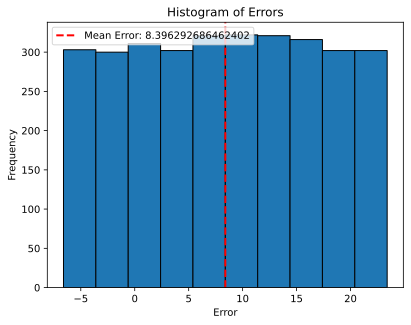

In [ ]:
plt.hist(errors, bins=10, edgecolor='black')

# mean and variance
mean_error = np.mean(errors)
variance_error = np.var(errors)
print(f'Mean Error: {mean_error}')
print(f'Variance of Error: {variance_error}')

# vertical line representing the mean of the errors
plt.axvline(x=mean_error, color='red', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error}')

plt.title('Histogram of Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()

plt.show()

Our errors are aproximately uniformly distributed. This lead us to the conclusion that, on average, the model is not consistently making predictions that are too high or too low across the dataset. It suggests a balanced performance in terms of overestimation and underestimation. the problem is that there is a high error variance. It suggests that the residual errors are more dispersed, indicating lower accuracy of the model in predicting observed values.

## Second model

The second model has the following structure:

- 5 convolutional layers
- Different Activation and Pooling Layers: ReLU activation function is applied after each convolutional layer, Batch normalization is applied after each convolutional layer and Max pooling which is applied after some of the convolutional layers.
- 6 fully connected layers.
- Dropout layers that are applied after some of the convolutional and fully connected layers with a dropout probability of 0.5 (default value).
- Adaptive average pooling is applied before flattening, reducing the spatial dimensions to (6, 6).
- The final output is a single value (regression output) obtained after passing through the last fully connected layer with a sigmoid activation function.

Epoch 1/20 - Loss: 287.22348158326866
Epoch 2/20 - Loss: 282.9813194797464
Epoch 3/20 - Loss: 280.40401918594154
Epoch 4/20 - Loss: 278.37577171848244
Epoch 5/20 - Loss: 276.89965287300004
Epoch 6/20 - Loss: 276.4266399226777
Epoch 7/20 - Loss: 275.9275022532842
Epoch 8/20 - Loss: 275.95543064483223
Epoch 9/20 - Loss: 275.8935799794654
Epoch 10/20 - Loss: 275.66774007718857
Epoch 11/20 - Loss: 276.24892237415054
Epoch 12/20 - Loss: 276.24934199084976
Epoch 13/20 - Loss: 275.42782530066086
Epoch 14/20 - Loss: 276.1018838751806
Epoch 15/20 - Loss: 276.07974013237106
Epoch 16/20 - Loss: 275.7889699021431
Epoch 17/20 - Loss: 276.4872270348954
Epoch 18/20 - Loss: 275.317675133274
Epoch 19/20 - Loss: 276.1046934781009
Epoch 20/20 - Loss: 276.52504197212113


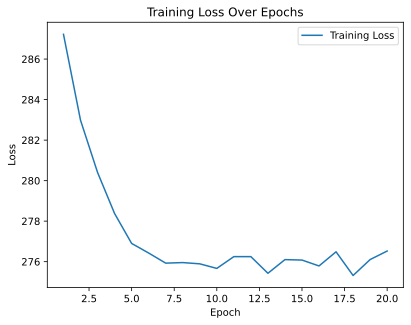

In [ ]:
class AgePrediction2(nn.Module):
    def __init__(self):
        super(AgePrediction2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(4096, 2048),
            nn.Sigmoid(),
            nn.Linear(2048, 1024),
            nn.Sigmoid(),
            nn.Linear(1024, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1),
            nn.Sigmoid()

        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


AgePrediction_model2 = AgePrediction2()

criterion = nn.MSELoss()
optimizer = optim.SGD(AgePrediction_model2.parameters(), lr=0.001)
initialize_weights(AgePrediction_model2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
AgePrediction_model2.to(device)

# list to save the training loss for each epoch
train_losses = []

num_epochs = 20
for epoch in range(num_epochs):
    AgePrediction_model2.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = AgePrediction_model2(inputs)

        loss = criterion(outputs.squeeze(), labels.float())  # Squeeze to remove extra dimensions
        loss.backward()

        torch.nn.utils.clip_grad_norm_(AgePrediction_model2.parameters(), max_norm=1)

        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss}")

plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The results of the second model are very similar to the first model.
Even modifying the architecture of the model we didn't obtain a model with a significantly lower loss (in this case it goes from a value of 287.22 to 276.53).
These model appears to have a lower loss function, so it is reasonable to think that will be better in predicting the age.

For this model, the histogram of errors wil be delivered with the presentation: we have finished the gpu and there was no time to re-run all the chunks.

In [ ]:
AgePrediction_model2.eval()
errors = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = AgePrediction_model2(inputs)
        predicted_age = outputs.squeeze() * 30 + 20
        errors.extend((predicted_age - (labels + 20)).cpu().numpy())

mean_error = np.mean(errors)
std_error = np.std(errors)

plt.hist(errors, bins=30, edgecolor='black')
plt.axvline(x=mean_error, color='red', linestyle='dashed', linewidth=2, label=f'Mean Error: {mean_error:.2f}')
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

print(f"Mean Error: {mean_error:.2f}")
print(f"Standard Deviation of Errors: {std_error:.2f}")

## Prediciton

In this part, we show some images from the test set providing predictions using our models.

In [ ]:
from PIL import Image
def load_and_preprocess_image(image_path):
    # Upload images
    image = Image.open(image_path).convert('RGB')

    # Same transformations used in the test
    preprocess = transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean = torch.Tensor(mean), std = torch.Tensor(std))
    ])

    image = preprocess(image).unsqueeze(0)
    image = image.to(device)

    AgePrediction_model.eval()

    with torch.no_grad():
      output = AgePrediction_model(image)

    predicted_value = output.item()
    print("The predicted age is:", predicted_value)

input_image_path = '/content/drive/MyDrive/deep_learning_project/120009.jpg'

load_and_preprocess_image(input_image_path)

The predicted age is: 0.7798758149147034


This is the outcome after the Sigmoid() function is applied to the final value, the age can be obtained by doing: value * 30 + 20.

Our predicted age in this case will be: 43,4.

For the prediction of the decond model we had the same problem that occurred for errors of the second model.
We have finished our gpu and so the predictions will be delivered in a better way in the presentation.

In [ ]:
input_image_path = '/content/drive/MyDrive/deep_learning_project/120009.jpg'
predicted_age = load_and_preprocess_image(input_image_path, AgePrediction_model2)
print("The predicted age is:", ((predicted_age*30)+20))


## Final comments
While doing this project we have encountered a lot of problems:

- The first was that we were dealing with a lot of images. Because of that we casually took only a small size for every class, maybe by doing this some images that could have helped were not selected.
- The second was the quality of the input images that maybe could have been tranformed in a better way. Infact, in our folders we have some images that were coloured and others that were black and white.
- To deal with such a problem would have required a more sophisticated architecture and so an higher computing capacity.
- These to models reported here are the ones that gave us the lower loss and that was the best combination of: batch-size (64), learning rate (0.0001 for the first model and 0.001 for the second model). Anyway The results are not satisfying.
- We decided (as said before) to do this analysis starting from the architecture of the AlexNet model, that is strong in classification and we tried to modify it for regression so the results are not good enough.
